# Data exploration

### Summary

This script contains the data exploration of the dataset created in the previous step, focused on exploring linear correlations between the variables and feature selection towards the final models.

### Import libraries
  
`tidyverse` for data manipulation and visualization  
`corrplot` for correlation-matrix plots  
`psych` for even fancier correlation plots (but check dependencies)  
`Boruta` for feature selection based on boruta method


In [1]:
library(tidyverse)
library(corrplot)
library(psych)
library(Boruta)

Warning message:
"package 'tidyverse' was built under R version 3.5.3"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  3.0.1     v dplyr   0.8.5
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

Warning message:
"package 'ggplot2' was built under R version 3.5.3"
Warning message:
"package 'tibble' was built under R version 3.5.3"
Warning message:
"package 'tidyr' was built under R version 3.5.3"
Warning message:
"package 'readr' was built under R version 3.5.3"
Warning message:
"package 'purrr' was built under R version 3.5.3"
Warning message:
"package 'dplyr' was built under R version 3.5.3"
Warning message:
"package 'stringr' was built under R version 3.5.3"
Warning message:
"package 'forcats' was built under R version 3.5.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



### Load data

Load config with the main paths and parameters

In [2]:
source("D:/TFM Data Science/config.R")

Load the generated dataset

In [5]:
points_df  <- read.csv(file.path(path_project, "35k_data.csv"), header = T)
head(points_df, 3)

x,y,NPP,Miami_NPP,bio_1,bio_10,bio_11,bio_12,bio_13,bio_14,...,bio_18,bio_19,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,...,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
46.95833,33.95833,67.574,823.1034,13.771042,25.048666,2.87500,483,95,1,...,4,216,14.734917,37.48008,904.1935,35.660,-3.654,39.314,3.674167,24.691500
-68.37500,62.62500,26.515,249.1695,-9.130459,6.202167,-24.35150,426,66,19,...,171,63,6.868083,16.24774,1251.1346,12.443,-29.828,42.271,5.645167,-20.405167
76.62500,56.29167,335.032,652.9854,0.299625,16.454500,-16.57317,423,62,14,...,176,65,10.541417,22.56490,1347.4503,24.651,-22.065,46.716,16.454500,-8.005834


Check NAs as well as sample points with values very close to 0 NPP

In [11]:
cat("Number of NAs in the dataframe")
points_df %>% is.na() %>% sum()

cat("Number of rows with NAs")
(nrow(points_df) - nrow(na.omit(points_df)))

cat("Number of rows with NPP = 0")
points_df %>% filter(NPP==0) %>% nrow()

cat("Number of rows with NPP value of 5 or less")
points_df %>% filter(NPP<=5) %>% nrow()

Number of NAs in the dataframe

[1] 900

Number of rows with NAs

[1] 45

Number of rows with NPP = 0

[1] 42

Number of rows with NPP value of 5 or less

[1] 322

Prepare the dataframe:
- remove variables 'x' (longitude) and Miami_NPP
- remove points with NPP of 5 or less
- transform latitude (variable 'y') into absolute values (latitudinal distance from the Equator)
- remove rows with NAs

In [20]:
df_modelo <- points_df %>% select(-x, -Miami_NPP) %>% filter(NPP > 5)
df_modelo$y <- abs(df_modelo$y)
df_modelo <- na.omit(df_modelo)
df_modelo <- cbind(select(df_modelo, NPP), select(df_modelo, -NPP))
head(df_modelo, 3)


NPP,y,bio_1,bio_10,bio_11,bio_12,bio_13,bio_14,bio_15,bio_16,...,bio_18,bio_19,bio_2,bio_3,bio_4,bio_5,bio_6,bio_7,bio_8,bio_9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<int>,...,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
67.574,33.95833,13.771042,25.048666,2.87500,483,95,1,83.80707,239,...,4,216,14.734917,37.48008,904.1935,35.660,-3.654,39.314,3.674167,24.691500
26.515,62.62500,-9.130459,6.202167,-24.35150,426,66,19,46.73623,181,...,171,63,6.868083,16.24774,1251.1346,12.443,-29.828,42.271,5.645167,-20.405167
335.032,56.29167,0.299625,16.454500,-16.57317,423,62,14,45.55902,176,...,176,65,10.541417,22.56490,1347.4503,24.651,-22.065,46.716,16.454500,-8.005834


### Correlations
Exploring linear correlations coefficients between all the predictive variables considered (bioclims and latitude) and the target variable (NPP).

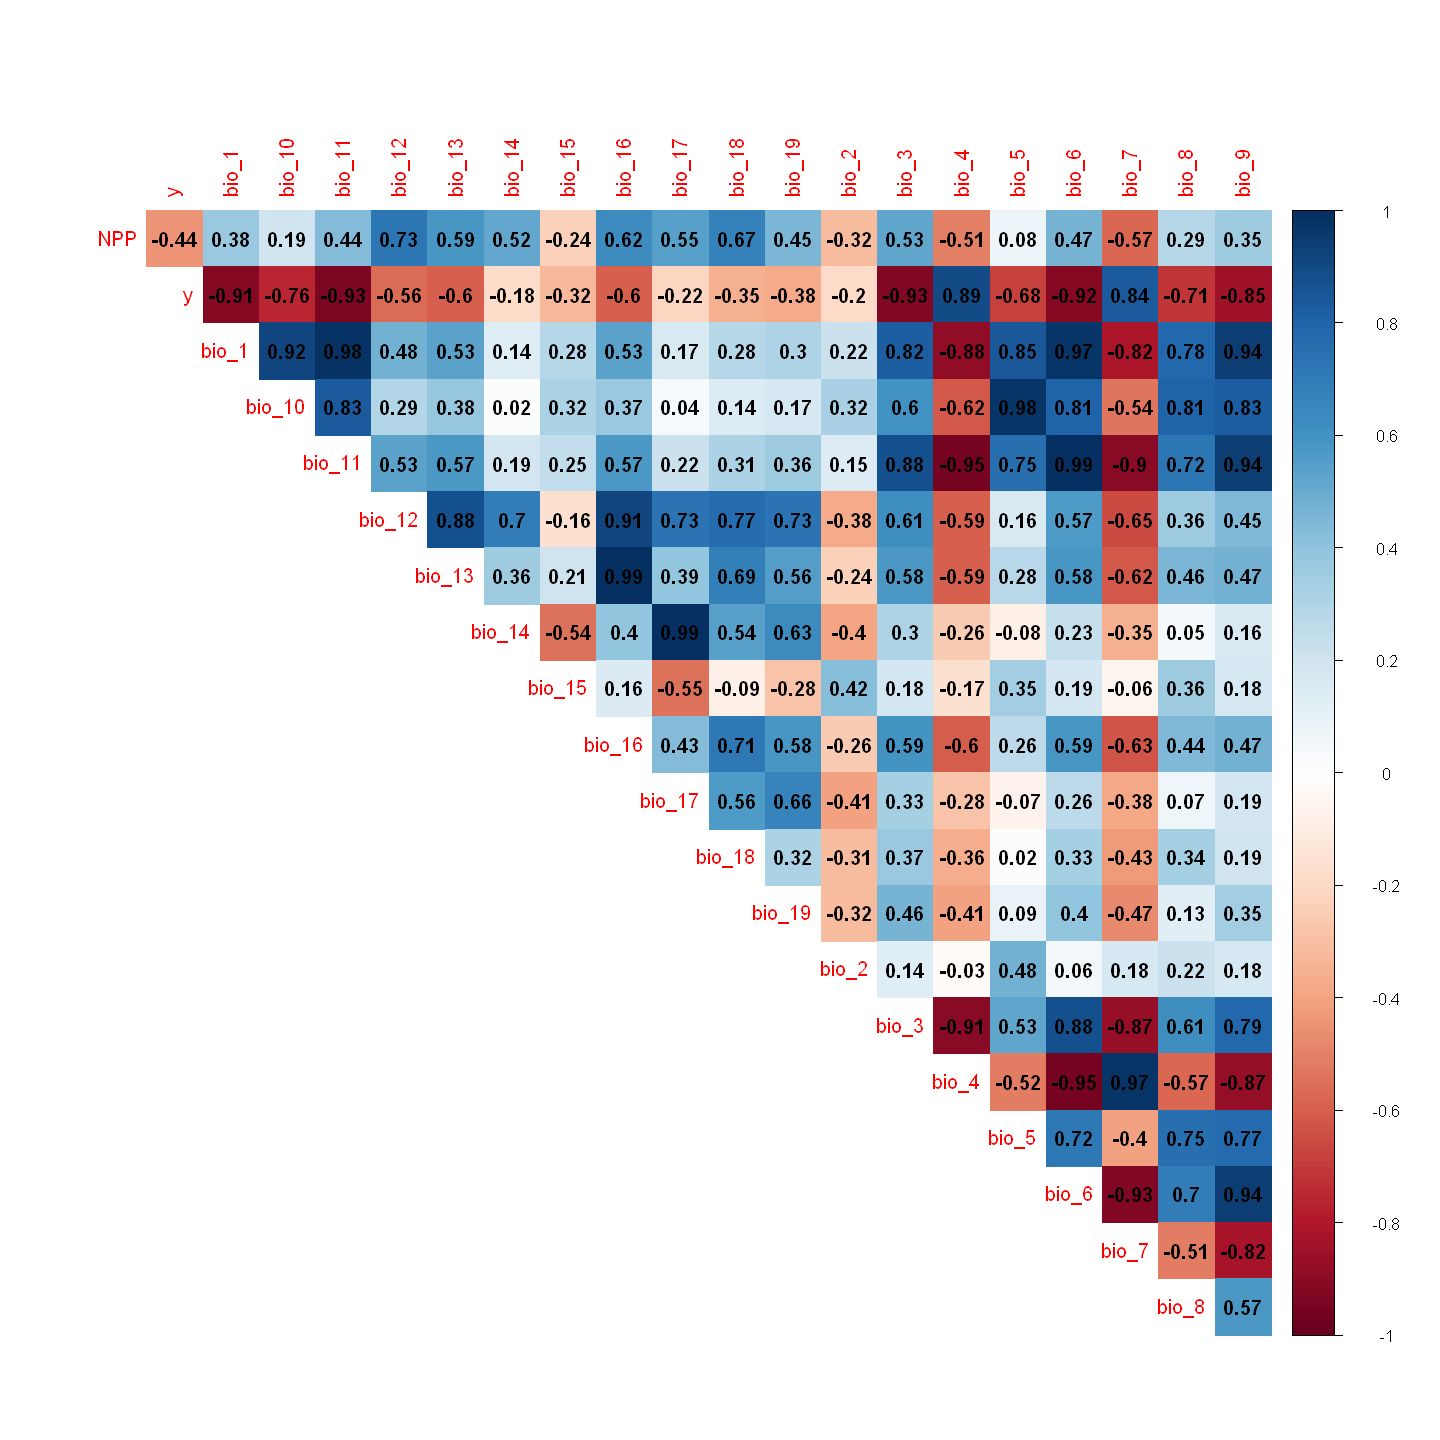

In [21]:
options(repr.plot.width = 12, repr.plot.height = 12)
df_modelo %>% cor() %>% corrplot(method="color", type="upper",addCoef.col = "black",diag = F)

**Some highlights:**  
Annual precipitation (bio 12)displays the highest correlation coefficient with NPP (0.73).  
Most temperature-related variables (bio 1 to bio 11) are highly correlated between them.  
Latitude (y) is also strongly correlated with temperature variables (which makes sense, given the differences in temperature and seasonality between tropical areas and Arctic/Antarctic regions)

Explore the correlations between the different subsets of variables: temperature-derived and precipitation-derived.  
First, create subsets

In [28]:
temp_df <- df_modelo %>% select("NPP", c(paste0("bio_",1:11)))
prec_df <- df_modelo %>% select("NPP", c(paste0("bio_",12:19)))

**Temperature variables**

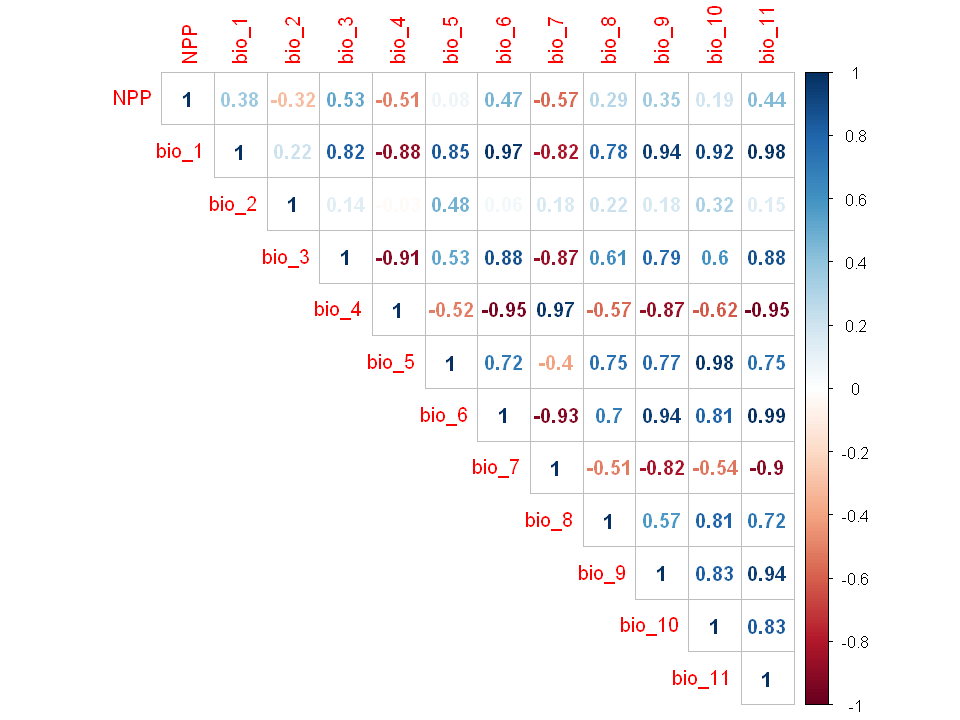

In [30]:
options(repr.plot.width = 8, repr.plot.height = 6)
temp_df %>% cor() %>% corrplot(method="number", type = "upper")

Some remarks:  
bio_1 (mean annual temperature) is correlated with almost every other temperature bioclim)  
bio_3 (isothermality) is calculated as bio_2/bio_7  (mean diurnal range / temperature anual range)  
bio_7 itself is also calculated as bio_5 / bio_6 (max temp of warmest month / min temp of coldest month  
bio_11 (mean temperature of coldest quarter) is very similar to bio_6 (min temp of coldest month    


This could potentially introduce some noise into the model, but since all of them have potential biological importance, they will remain in the dataset until the feature selection process.  
It is however important to further explore distributions and non-linear relationships between them, using the graphs generated by `psych::pair.panels()`

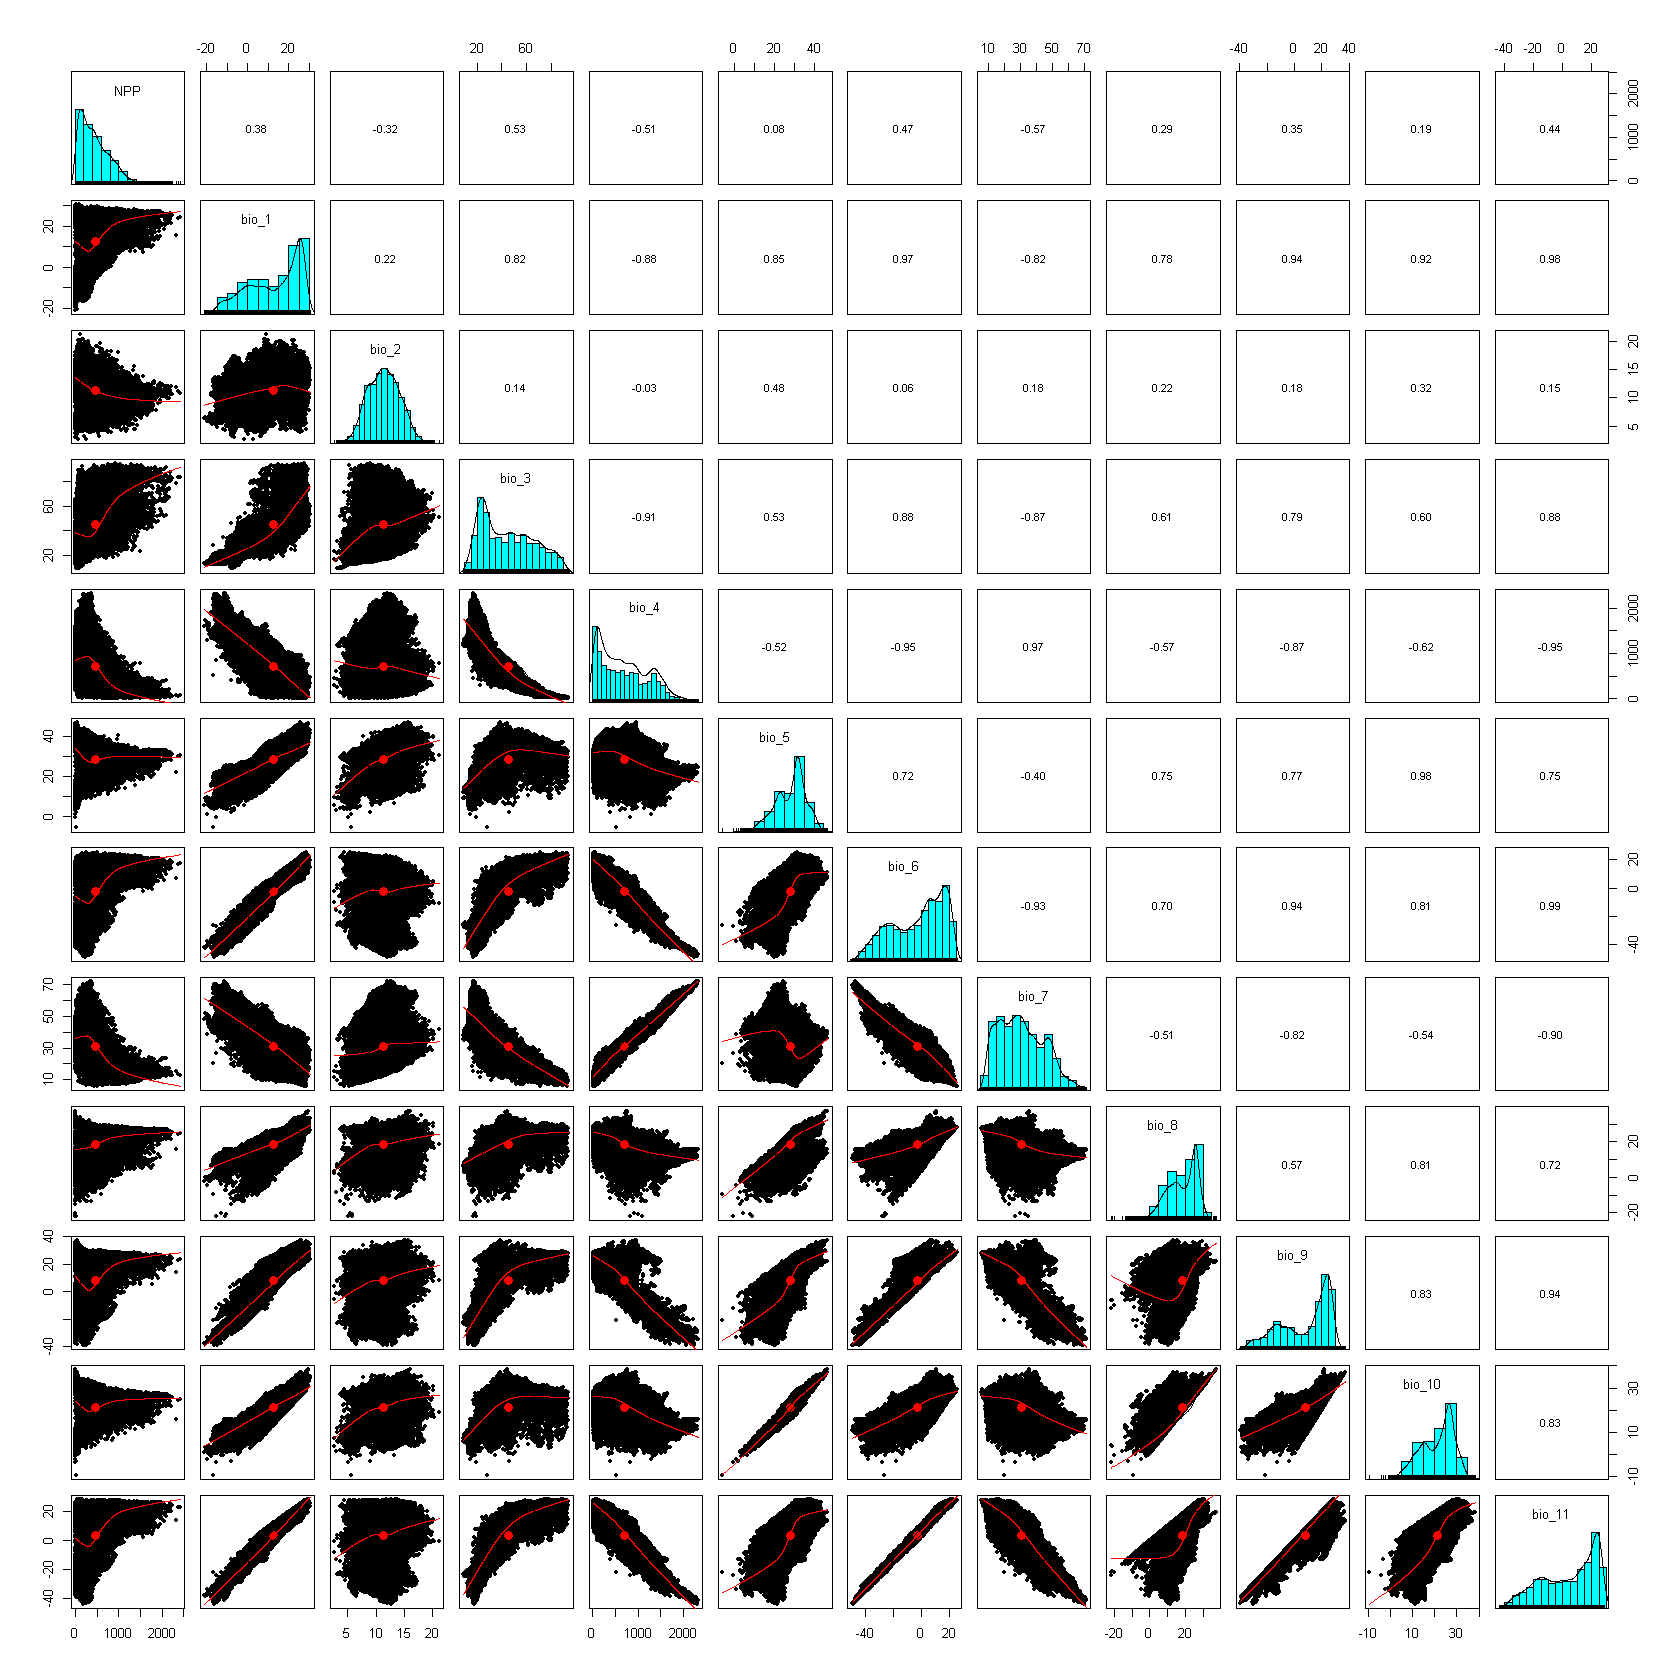

In [32]:
options(repr.plot.width = 14, repr.plot.height = 14)
temp_df %>% pairs.panels(method = "pearson", density = TRUE, ellipses = TRUE)

**Precipitation variables**  
Same process as with temperature

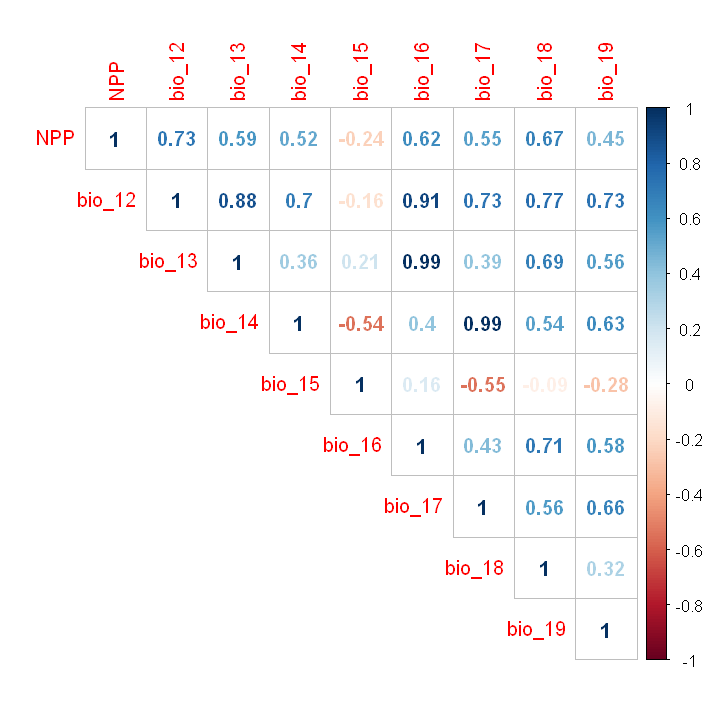

In [35]:
options(repr.plot.width = 6, repr.plot.height = 6)
prec_df %>% cor() %>% corrplot(method="number", type = "upper")

Veeeeery high correlation coefficient between bio_13 (prec. of the wettest month) and bio_16 (prec. of wettest quarter), as well as between bio_14 and bio_17 (same, but for driest month and driest quarter). Againm this makes sense in the nature of the data, and will not be discarded yet.

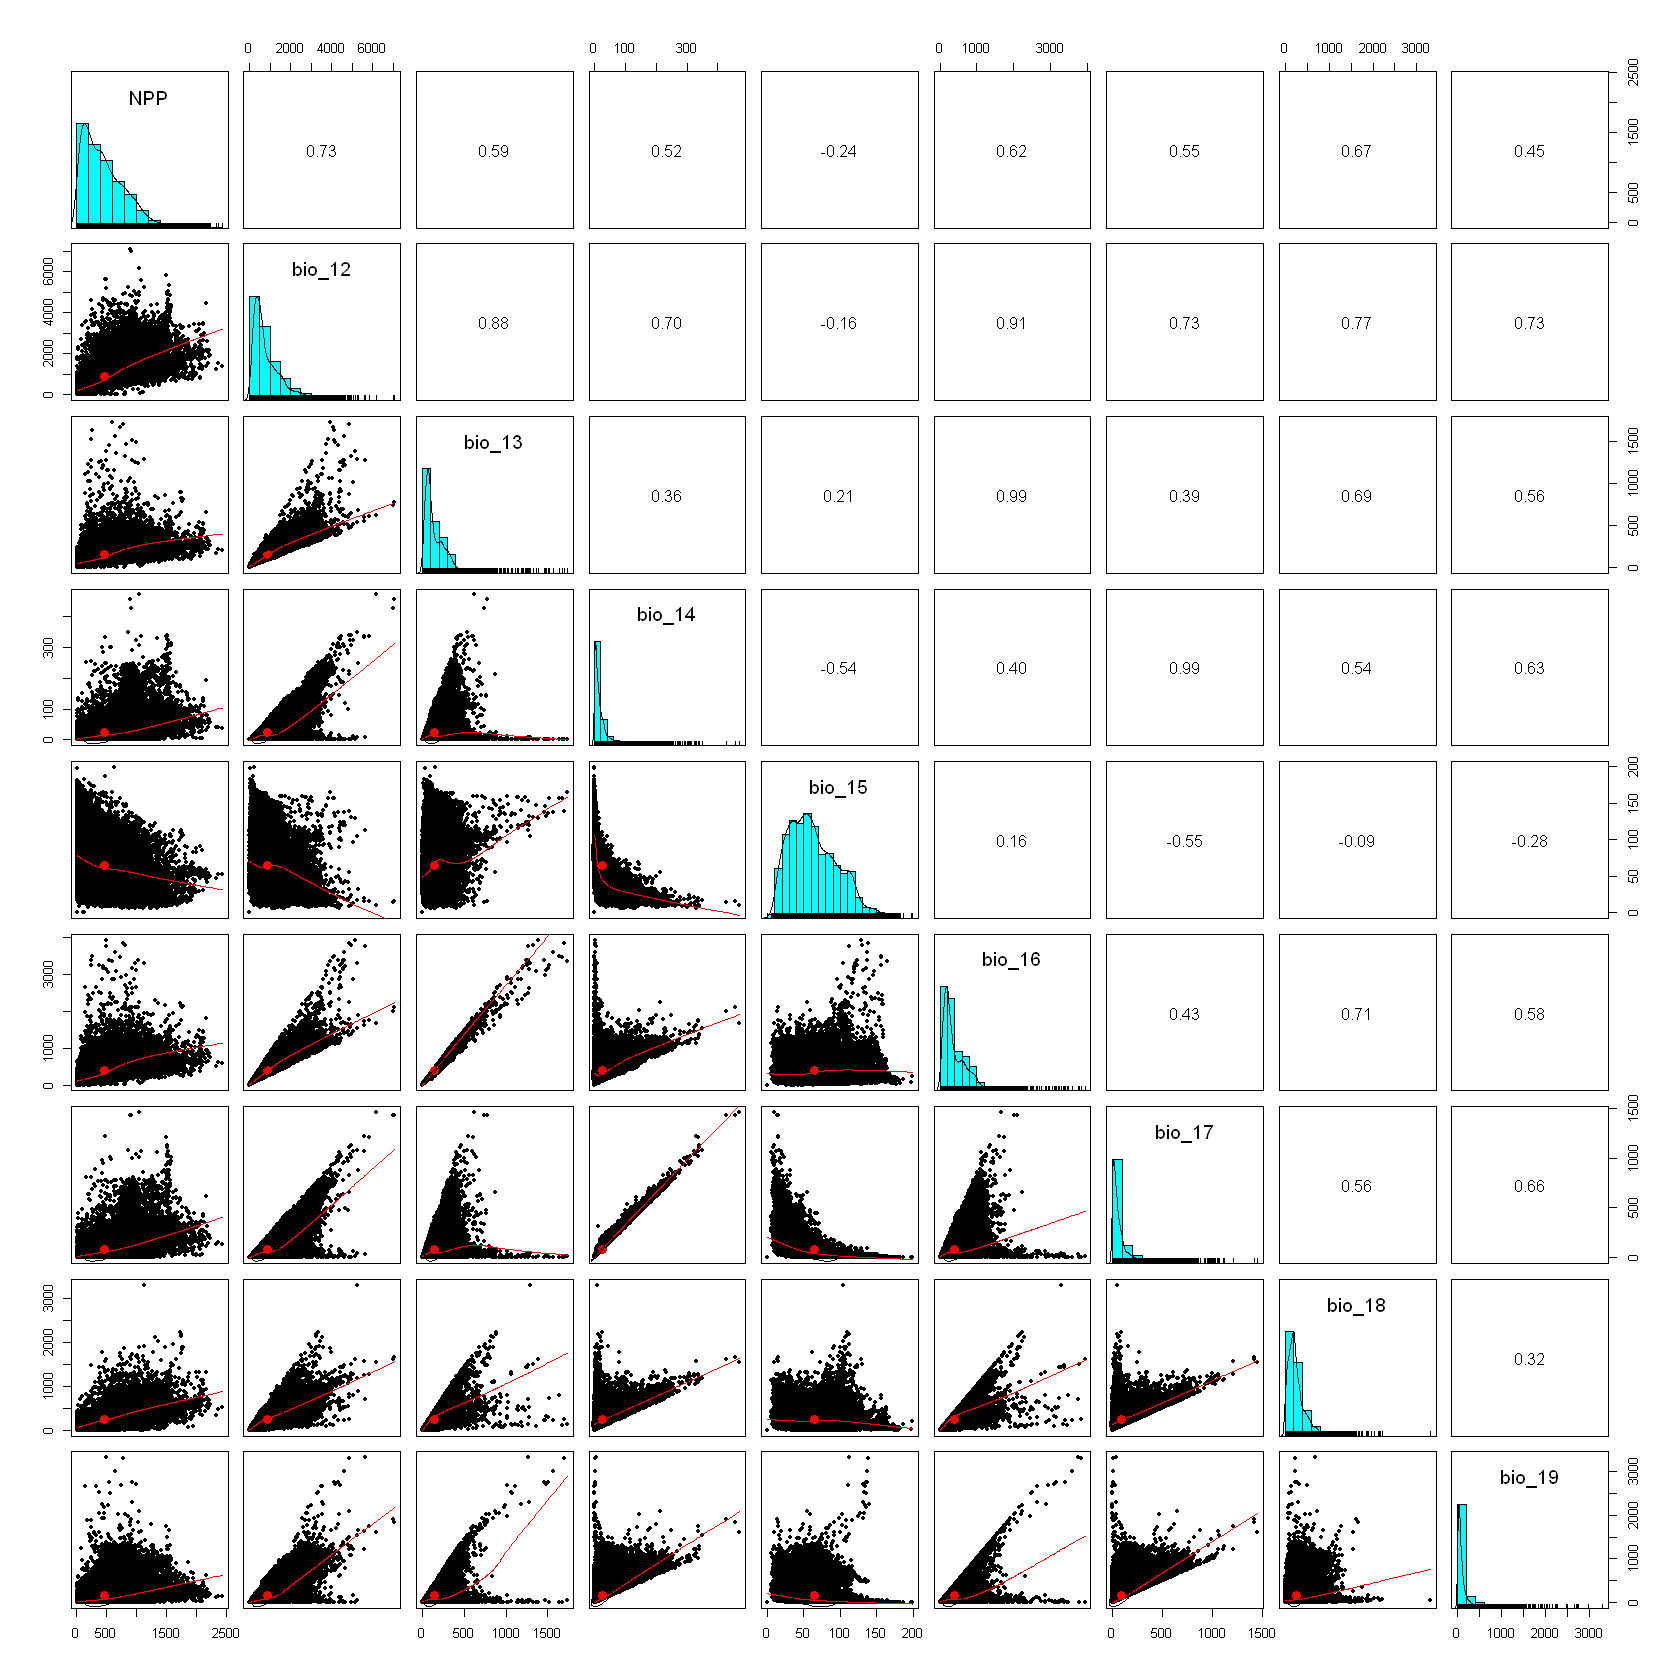

In [36]:
options(repr.plot.width = 14, repr.plot.height = 14)
prec_df %>% pairs.panels(method = "pearson", density = TRUE, ellipses = TRUE)

### Considerations about distribution of the variables

Although the variables will initially be included in their raw distribution, alternative tranformations will also be considered for a better fit in some of the models:  
- min-max normalization for the climatic variables and latitude
- log transformation for the NPP

### Boruta method for variable selection

In [24]:
boruta_output <- Boruta(NPP~., data=df_modelo, doTrace=2)


 1. run of importance source...

 2. run of importance source...

 3. run of importance source...

 4. run of importance source...

 5. run of importance source...

 6. run of importance source...

 7. run of importance source...

 8. run of importance source...

 9. run of importance source...

 10. run of importance source...

 11. run of importance source...

After 11 iterations, +8.7 mins: 

 confirmed 20 attributes: bio_1, bio_10, bio_11, bio_12, bio_13 and 15 more;

 no more attributes left.




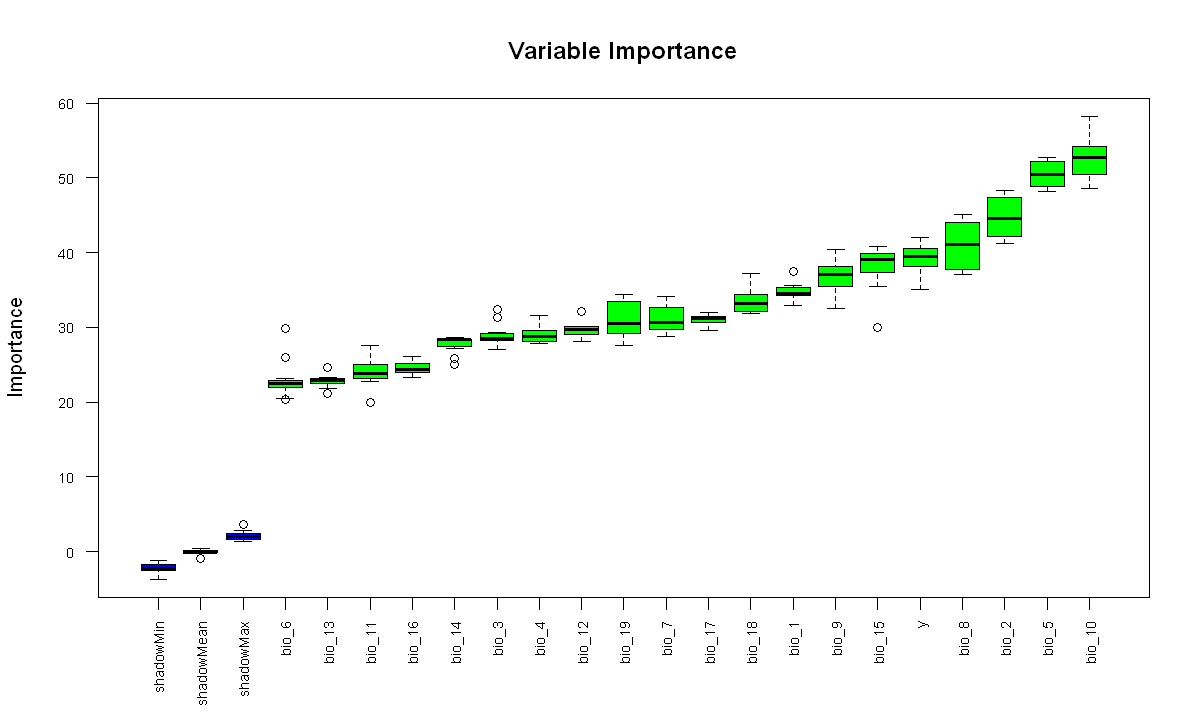

In [27]:
options(repr.plot.width = 10, repr.plot.height = 6)
plot(boruta_output, cex.axis=.7, las=2, xlab="", main="Variable Importance")


In [23]:
boruta_output$finalDecision

y     bio_1    bio_10    bio_11    bio_12    bio_13    bio_14    bio_15 
Confirmed Confirmed Confirmed Confirmed Confirmed Confirmed Confirmed Confirmed 
   bio_16    bio_17    bio_18    bio_19     bio_2     bio_3     bio_4     bio_5 
Confirmed Confirmed Confirmed Confirmed Confirmed Confirmed Confirmed Confirmed 
    bio_6     bio_7     bio_8     bio_9 
Confirmed Confirmed Confirmed Confirmed 
Levels: Tentative Confirmed Rejected

All of the proposed variables are confirmed as informative, and since the models that will be used are not always limited by colinearity of variables, all of them will be used in the future analysis.